In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [110]:
a_true, b_true = 1, 0.1
x = np.linspace(0.1,1,10)

def mean(theta):
    a,b = theta
    return a*b**2*x + 1

y_mean = mean([a_true, b_true])
std = .1*abs(max(y_mean))
#plt.errorbar(x, y_mean, std)

In [111]:
#plt.plot(x, y_mean)

In [112]:
y_random = np.random.randn(200, len(x)) 

In [113]:
y_sample = y_random * std + y_mean
cov = np.cov(y_sample.T)

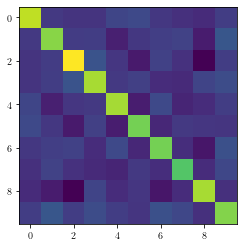

In [114]:
plt.imshow(cov)

In [115]:
import iminuit
from iminuit import Minuit
def lnL(a, b):
    theta = a, b
    y_th = mean(theta)
    inv_cov = np.linalg.inv(cov)
    d = y_sample[0] - y_th
    res = -0.5*np.sum(d*inv_cov.dot(d))
    return res

def lnL_emcee(theta):
    a, b = theta
    return lnL(a, b)
def neg_lnL_minuit(a, b):
    return -lnL(a, b)

minuit = Minuit(neg_lnL_minuit, a = a_true, b= b_true,
                   errordef = 0.5)
        
minuit.migrad(),minuit.hesse(),minuit.minos()
a = minuit.matrix()
a = np.array(a)

In [116]:
import emcee
initial = [a_true,b_true]
npath = 200
nwalkers = 600
pos = initial + 0.001 * np.random.randn(nwalkers, len(initial))
nwalkers, ndim = pos.shape
sampler_single = emcee.EnsembleSampler(nwalkers, ndim, lnL_emcee)
print('Single cluster : running...')
sampler_single.run_mcmc(pos, npath, progress=True);

  0%|          | 0/200 [00:00<?, ?it/s]

Single cluster : running...


100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


In [117]:
MLE = [minuit.values['a'], minuit.values['b']]

In [118]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import DATAOPS_Fisher_matrix as fisher
Fisher_matrix= fisher.Fisher_Matrix(MLE, mean, cov)
S_matrix= fisher.S_Fisher_Matrix(MLE, mean, cov)
Q_matrix= fisher.Q_Fisher_Matrix(MLE, mean, cov)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
Fisher_matrix

array([[ 0.10724604,  2.12967415],
       [ 2.12967415, 42.29071935]])

In [120]:
cov_param = np.linalg.inv(Fisher_matrix)

In [121]:
cov_param

array([[ 1.01626979e+15, -5.11772685e+13],
       [-5.11772685e+13,  2.57718260e+12]])

In [122]:
def lnL_parameters_FS(theta):
    
    theta = np.array(theta)
    
    dtheta = np.array(theta) - MLE
    
    for i in range(len(theta)):
        
        if abs(dtheta[i])/np.sqrt(cov_param[i,i]) > 1: return - np.inf
    
    lnL_Fisher = fisher.lnL_Fisher(theta, MLE, Fisher_matrix)
    lnL_S_Fisher = fisher.lnL_S_Fisher(theta, MLE, S_matrix)

    return lnL_Fisher + lnL_S_Fisher

def lnL_parameters_FSQ(theta):
    
    dtheta = np.array(theta) - MLE
    
    #for i in range(len(theta)):
    #    
     #   if abs(dtheta[i])/np.sqrt(cov_param[i,i]) > 1: return - np.inf
    
    lnL_Fisher = fisher.lnL_Fisher(theta, MLE, Fisher_matrix)
    lnL_S_Fisher = fisher.lnL_S_Fisher(theta, MLE, S_matrix)
    lnL_Q_Fisher = fisher.lnL_Q_Fisher(theta, MLE, Q_matrix)
    
    return lnL_Fisher +  lnL_Q_Fisher + lnL_S_Fisher

In [123]:
initial = MLE
npath = 300
nwalkers = 600
pos = initial + 0.001 * np.random.randn(nwalkers, len(initial))
sampler_param_FS = emcee.EnsembleSampler(nwalkers, ndim, lnL_parameters_FS)
print('Single cluster : running...')
sampler_param_FS.run_mcmc(pos, npath, progress=True);

  0%|          | 0/300 [00:00<?, ?it/s]

Single cluster : running...


100%|██████████| 300/300 [00:09<00:00, 30.03it/s]


In [124]:
sampler_param_FSQ = emcee.EnsembleSampler(nwalkers, ndim, lnL_parameters_FSQ)
print('Single cluster : running...')
sampler_param_FSQ.run_mcmc(pos, npath, progress=True);

  0%|          | 0/300 [00:00<?, ?it/s]

Single cluster : running...


100%|██████████| 300/300 [00:16<00:00, 17.75it/s]


In [125]:
### See lnL 1D

In [126]:
#a_array = np.linspace(0.9999,1,30)
#for a_ in a_array:
##    plt.scatter(a_, lnL_parameters_F([a_, b_true]), c='k')
#    plt.scatter(a_, lnL_parameters_FS([a_, b_true]),  c='r')
#    plt.scatter(a_, lnL_parameters_FSQ([a_, b_true]),  c='g')

In [127]:
discard, thin = 100, 10
f = sampler_single.get_chain(discard = discard, thin = thin, flat = True)
s = sampler_param_FSQ.get_chain(discard = discard, thin = thin, flat = True)
t = sampler_param_FS.get_chain(discard = discard, thin = thin, flat = True)

(-564524.0753776772,
 415588.87507892307,
 -2.2157716974365473,
 4.313100248452546)

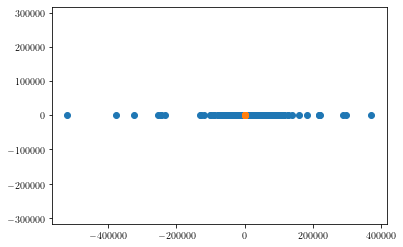

In [128]:
plt.scatter(f[:,0], f[:,1])
plt.scatter(s[:,0], s[:,1])
#plt.scatter(t[:,0], t[:,1])
plt.axis('equal')

In [129]:
np.linalg.inv(Fisher_matrix)

array([[ 1.01626979e+15, -5.11772685e+13],
       [-5.11772685e+13,  2.57718260e+12]])

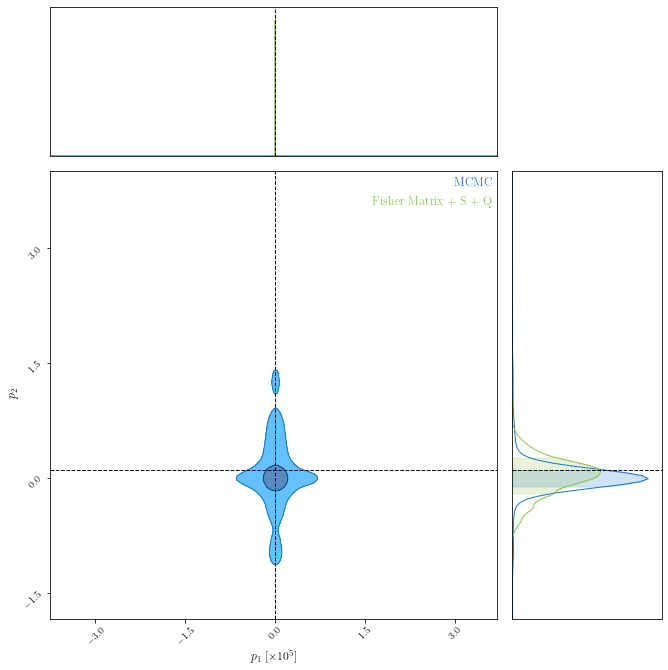

In [130]:
flat_sample_single = sampler_single.get_chain(discard = discard, thin = thin, flat = True)
import numpy as np
from chainconsumer import ChainConsumer
labels = [r'$p_1$',r'$p_2$', ]

#posterior
cs = ChainConsumer()
cs.add_chain(sampler_single.get_chain(discard = discard, thin = thin, flat = True),
             parameters=labels, name = 'MCMC')
#data = np.random.multivariate_normal(MLE, np.linalg.inv(Fisher_matrix), size=100000)
#cs.add_chain(data,parameters=labels, name = 'Fisher Matrix')
#Fisher + S
#cs.add_chain(sampler_param_FS.get_chain(discard = discard, thin = thin, flat = True),
#             parameters=labels, name = 'Fisher Matrix + S')
#Fisher + S + Q
cs.add_chain(sampler_param_FSQ.get_chain(discard = discard, thin = thin, flat = True),
             parameters=labels, name = 'Fisher Matrix + S + Q')
#cs.configure(linestyles=["--", "-", '-', '-'], linewidths=[1.0, 2.0, 1.0,1],
#            shade=[True, False, False, True], shade_alpha=[0.2, 0.0, 0.1,0.1], sigma2d = True)
fig = cs.plotter.plot(figsize="column", truth=[a_true, b_true])
fig.set_size_inches(10, 10)